In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from PIL import Image
from pathlib import Path
from numpy import linalg as LA
from numpy.linalg import inv
from sklearn.mixture import GaussianMixture

# Data processing

In [2]:
# chose 25 folders randomly
chosen = np.random.default_rng(2022).choice(np.arange(1, 68 + 1), 25, replace=False)

# Load images 
images = []
labels = []

directory = Path("/Python_programme/Jupyter/PIE_origin")
for i in chosen:
    # split train and test
    sub_images = []
    sub_labels = []
    sub_directory = directory / str(i)
    
    files = list(sub_directory.glob("*.jpg"))
    np.random.default_rng(2023).shuffle(files)
    for filename in files:
        im = Image.open(filename)
        sub_images.append(np.array(im))
        sub_labels.append(i)  # Use folder numbers as labels
    images.append(sub_images)
    labels.append(sub_labels)
    
# len(images)
# len(labels)

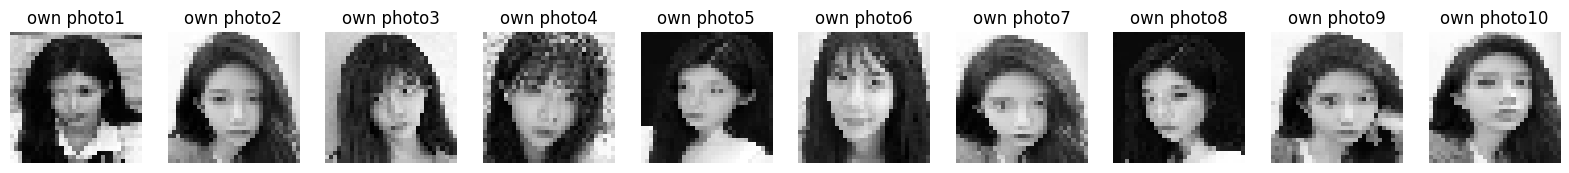

In [3]:
# process own photos
own_imgs= []
own_labels = []

for i in range(1, 11):
    img = cv2.imread('/Python_programme/Jupyter/own_photos/'+ str(i)+'.jpg', cv2.IMREAD_GRAYSCALE)  # convert to gray image
    img = cv2.resize(img, (32, 32), interpolation = cv2.INTER_CUBIC)
    own_imgs.append(img)   # create imgs in desired format
    own_labels.append(69)  # label own photos as class 69
    
# split training and testing data sets 
own_train_imgs = own_imgs[0:7]      # first 7 phots for training
own_test_imgs = own_imgs[7:]        # last 3 photos for testing
own_train_labels = own_labels[0:7]  
own_test_labels = own_labels[7:]

# visualize photos
fig = plt.figure(figsize = (20,10))

for i in range(1, 11):
    plt.subplot(1, 10, i)
    plt.imshow(own_imgs[i-1], cmap = 'gray' )
    plt.title('own photo'+ str(i))
    plt.axis('off')
    
plt.show()

In [4]:
# Train-test split
NUM_TRAIN_IMAGES_PER_SUBJECT = np.int_(np.around(0.7 * 170))

images_train, images_test = np.split(np.array(images), [NUM_TRAIN_IMAGES_PER_SUBJECT], axis=1)
labels_train, labels_test = np.split(np.array(labels), [NUM_TRAIN_IMAGES_PER_SUBJECT], axis=1)
own_images_train, own_images_test = np.split(np.array(own_imgs), [7])
own_labels_train, own_labels_test = np.split(np.array(own_labels), [7])

import warnings
warnings.filterwarnings('ignore', category=Warning)

# Flatterning
PIE_images_train = images_train.reshape(25*NUM_TRAIN_IMAGES_PER_SUBJECT, 1024)
own_images_train = own_images_train.reshape(7, 1024)
images_test = images_test.reshape(25*(170-NUM_TRAIN_IMAGES_PER_SUBJECT), 1024)
own_images_test = own_images_test.reshape(3, 1024)

labels_train = labels_train.reshape(25*NUM_TRAIN_IMAGES_PER_SUBJECT)
labels_test = labels_test.reshape(25*(170-NUM_TRAIN_IMAGES_PER_SUBJECT))

# Combine PIE images and own photos to get full train and test sets
full_train_set = np.append(PIE_images_train,own_images_train,axis=0,)
full_train_labels = np.append(labels_train, own_labels_train)

full_test_set = np.append(images_test,own_images_test,axis=0,)
full_test_labels = np.append(labels_test, own_labels_test)

# GMM

In [5]:
X_train = full_train_set
y_train = full_train_labels

## 1. Define GMM with 3 Gaussian components

In [6]:
def GMM(X, d):   # X is dataset and d is dimesion of data
    gmm = GaussianMixture(n_components=3).fit(X)
    pred_y = gmm.predict(X)

    fig = plt.figure()
    ax = fig.add_subplot(8, 10, (41, 80))
    for i in range(3):
        ax.scatter(X[pred_y == i][:, 0], X[pred_y == i][:, 1],label=i,)

    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.title.set_text('Clustering results for data in %d dimension' %d)
    ax.legend()
    
    for i in range(3):
        for j in range(10):
            faces = fig.add_subplot(8, 10, i * 10 + j + 1)
            faces.set_axis_off()
            faces.imshow(X_train[pred_y == i][j * 15].reshape(32, 32), cmap="gray")

## 2. use raw face images

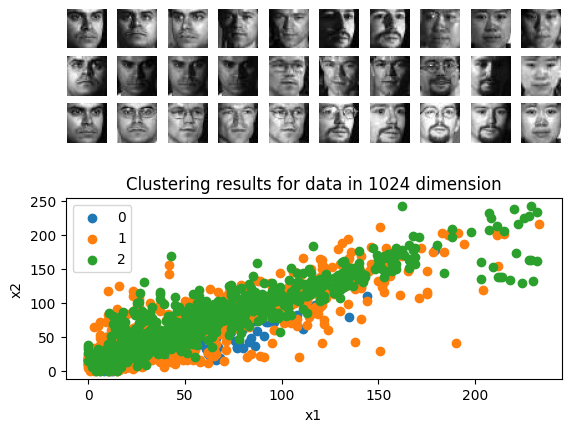

In [7]:
GMM(X_train, 1024)

## 3. use face vectors after PCA pre-processing with dimensionality of 200

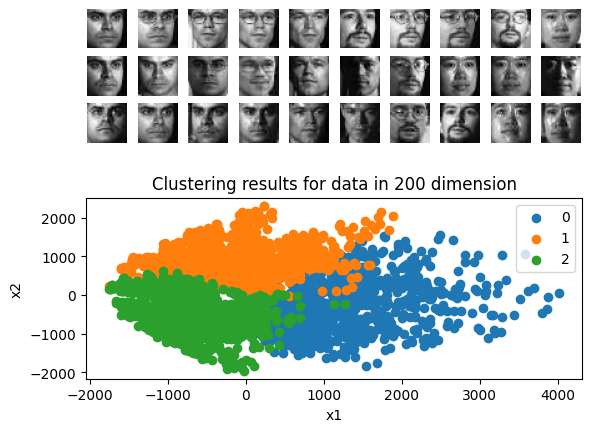

In [8]:
mean_X = np.mean(X_train, axis=0)
centered_X = X_train - mean_X

u, s, vh = np.linalg.svd(centered_X, full_matrices=False)
s_matrix = np.diag(s)

X_pca = u[:, :200] @ s_matrix[:200, :200]

GMM(X_pca[:, :200], 200)

## 4. use face vectors after PCA pre-processing with dimensionality of 80

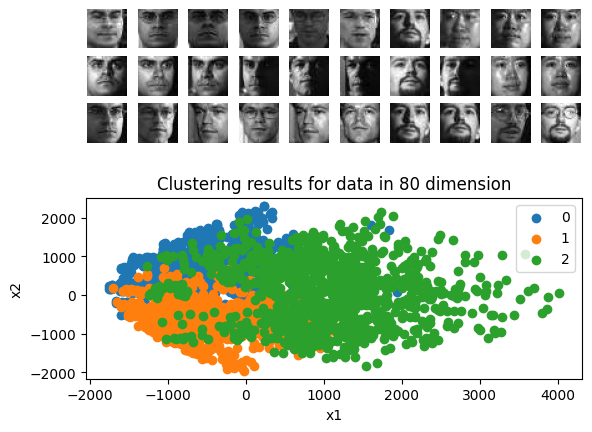

In [9]:
GMM(X_pca[:, :80], 80)